In [16]:
import numpy as np
import networkx as nx
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

# Step 1: Load Graph Data and Create Graph
def get_graph(filepath):
    dataGraph = pd.read_csv(filepath, sep=' ', skiprows=0)
    graph = nx.Graph()
    edges = np.array(dataGraph)
    for edge in edges:
        print('leftNode:', edge[0], 'rightNode:', edge[1])
        graph.add_edge(edge[0], edge[1])
    return graph

# Step 2: Generate Node2Vec Edge Embeddings
def get_edge_embeddings(graph, savepath):
    node2vec = Node2Vec(graph, dimensions=64, walk_length=5, num_walks=10, workers=1)
    model = node2vec.fit(window=10, min_count=1, batch_words=1)
    edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
    edges_kv = edges_embs.as_keyed_vectors()
    edges_kv.save_word2vec_format(savepath)
    return edges_kv

# Step 3: Prepare Data for Generative and Discriminative Models
def prepare_data(graph, edges_kv):
    X, y = [], []
    for edge in graph.edges():
        u, v = edge
        if f"{u}_{v}" in edges_kv:
            X.append(edges_kv[f"{u}_{v}"])
            y.append(1)  # Positive sample
        else:
            X.append(np.random.random(64))  # Random vector for negative sample
            y.append(0)  # Negative sample
    return np.array(X), np.array(y)

# Step 4: Build Generative Model for Link Prediction
def build_generative_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 5: Build Discriminative Classifier for Link Types
def build_discriminative_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # Assuming 4 link types
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 6: Train the Models
def train_model(model, X_train, y_train, X_test, y_test, epochs=10):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))
    return history

# Step 7: Evaluate Model Performance
def evaluate_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}, Precision: {precision}, AUC: {auc}")
    return accuracy, precision, auc

# Step 8: Plot Training Metrics
def plot_metrics(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Step 9: Main Function to Run the Process
def pro_data_main(dataset):
    print("Processing dataset:", dataset)
    pathReal = f'Datasets/{dataset}/realData.csv'
    graph = get_graph(pathReal)  # Create graph from real data
    savepath = f'Datasets/node2vecFeature/{dataset.lower()}Feature.txt'
    edges_kv = get_edge_embeddings(graph, savepath)  # Generate edge embeddings

    # Prepare data for training
    X, y = prepare_data(graph, edges_kv)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Build and train generative model
    gen_model = build_generative_model(X_train.shape[1])
    gen_history = train_model(gen_model, X_train, y_train, X_test, y_test)

    # Evaluate and plot metrics for generative model
    evaluate_model(gen_model, X_test, y_test)
    plot_metrics(gen_history)

    # Build and train discriminative model
    dis_model = build_discriminative_model(X_train.shape[1])
    dis_history = train_model(dis_model, X_train, y_train, X_test, y_test)

    # Evaluate and plot metrics for discriminative model
    evaluate_model(dis_model, X_test, y_test)
    plot_metrics(dis_history)

# Entry Point
if __name__ == '__main__':
    datasets = ['Facebook']
    for dataset in datasets:
        pro_data_main(dataset)


Processing dataset: Facebook
leftNode: 2 rightNode: 126
leftNode: 3 rightNode: 293
leftNode: 4 rightNode: 2004
leftNode: 4 rightNode: 1182
leftNode: 4 rightNode: 1443
leftNode: 4 rightNode: 187
leftNode: 4 rightNode: 1489
leftNode: 4 rightNode: 1882
leftNode: 4 rightNode: 2282
leftNode: 4 rightNode: 1879
leftNode: 4 rightNode: 1377
leftNode: 4 rightNode: 1997
leftNode: 5 rightNode: 1840
leftNode: 5 rightNode: 945
leftNode: 6 rightNode: 1193
leftNode: 6 rightNode: 290
leftNode: 10 rightNode: 14
leftNode: 13 rightNode: 1744
leftNode: 13 rightNode: 395
leftNode: 13 rightNode: 2280
leftNode: 13 rightNode: 213
leftNode: 13 rightNode: 501
leftNode: 13 rightNode: 1494
leftNode: 14 rightNode: 1041
leftNode: 14 rightNode: 1187
leftNode: 14 rightNode: 2075
leftNode: 14 rightNode: 1943
leftNode: 14 rightNode: 2327
leftNode: 15 rightNode: 353
leftNode: 17 rightNode: 1626
leftNode: 18 rightNode: 2224
leftNode: 18 rightNode: 961
leftNode: 18 rightNode: 1209
leftNode: 19 rightNode: 330
leftNode: 19 r

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.76it/s]
Generating edge features: 100%|██████████████████████████████████████████████████████████████████████████████| 975106/975106.0 [00:06<00:00, 148817.51it/s]


Epoch 1/10
43/43 [==============================] - 2s 19ms/step - loss: 0.2139 - accuracy: 0.8975 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 2/10
43/43 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 7.3727e-04 - val_accuracy: 1.0000
Epoch 3/10
43/43 [==============================] - 0s 6ms/step - loss: 2.9789e-04 - accuracy: 1.0000 - val_loss: 1.0344e-04 - val_accuracy: 1.0000
Epoch 4/10
43/43 [==============================] - 0s 6ms/step - loss: 5.7884e-05 - accuracy: 1.0000 - val_loss: 3.6177e-05 - val_accuracy: 1.0000
Epoch 5/10
43/43 [==============================] - 0s 5ms/step - loss: 2.5127e-05 - accuracy: 1.0000 - val_loss: 1.9478e-05 - val_accuracy: 1.0000
Epoch 6/10
43/43 [==============================] - 0s 6ms/step - loss: 1.4703e-05 - accuracy: 1.0000 - val_loss: 1.2487e-05 - val_accuracy: 1.0000
Epoch 7/10
43/43 [==============================] - 0s 6ms/step - loss: 9.8240e-06 - accuracy: 1.0000 - val_loss: 8.7133e-0

C:\Users\AHAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [18]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.autograd import Variable, Function
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
import re, networkx as nx
import pandas as pd
import numpy as np
import time, os, random

# ===================
# GA CONFIGURATION
# ===================
NUM_EPOCHS = 50
POPULATION_SIZE = 10
NUM_GENERATIONS = 5
MUTATION_RATE = 0.1

class edgeFeatures:
    def __init__(self, label=None, type=None, embeddings=None):
        self.label = label
        self.type = type
        self.embeddings = embeddings

def structuralGraph(realFileName, fakeFileName, dataset):
    dataReal = pd.read_csv(realFileName, sep=' ')
    dataFake = pd.read_csv(fakeFileName, sep=' ')

    train_Real_Graph = nx.Graph()
    train_Fake_Graph = nx.Graph()
    test_Real_Graph = nx.Graph()
    test_Fake_Graph = nx.Graph()

    real_edges = np.array(dataReal.iloc[:, 0:3])
    fake_edges = np.array(dataFake.iloc[:, 0:3])

    dataNewType = [9, 8, 7, 6, 5, 4] if dataset.lower() == 'facebook' else [2]

    for edge in real_edges:
        graph = test_Real_Graph if edge[2] in dataNewType else train_Real_Graph
        graph.add_edge(edge[0], edge[1], relationship=edge[2])

    for edge in fake_edges:
        graph = test_Fake_Graph if edge[2] in dataNewType else train_Fake_Graph
        graph.add_edge(edge[0], edge[1], relationship=edge[2])

    return train_Real_Graph, train_Fake_Graph, test_Real_Graph, test_Fake_Graph

def get_train_validate_test(dataset):
    realFile = f'Datasets/{dataset}/realData.csv'
    fakeFile = f'Datasets/{dataset}/fakeData.csv'
    train_real, train_fake, test_real, test_fake = structuralGraph(realFile, fakeFile, dataset)

    node2vecFile = f'Datasets/node2vecFeature/{dataset}Feature.txt'
    data = pd.read_csv(node2vecFile, sep=' ', skiprows=1, header=None)

    edges = np.array(data.iloc[:, 0:2])
    embeddings = np.array(data.iloc[:, 2:])
    
    train_data, test_data = [], []

    for i, (nodeL, nodeR) in enumerate(edges):
        edgeFeature = edgeFeatures()
        # In the loop over the edges
        nodel = int(re.sub(r"\D", "", str(nodeL[i][0]).strip()))  # Clean and strip unwanted characters
        noder = int(re.sub(r"\D", "", str(nodeR[i][0]).strip()))  # Handle parentheses or stray symbols

        
        if train_real.has_edge(nodel, noder) or train_fake.has_edge(nodel, noder):
            label = 1 if train_real.has_edge(nodel, noder) else 0
            edgeFeature.embeddings = embeddings[i]
            edgeFeature.label = label
            train_data.append(edgeFeature)
        elif test_real.has_edge(nodel, noder) or test_fake.has_edge(nodel, noder):
            label = 1 if test_real.has_edge(nodel, noder) else 0
            edgeFeature.embeddings = embeddings[i]
            edgeFeature.label = label
            test_data.append(edgeFeature)

    train, validate = train_test_split(train_data, test_size=0.2)
    return create_dataloader(train), create_dataloader(validate), create_dataloader(test_data)

def create_dataloader(data):
    dataset = [[torch.tensor(e.embeddings, dtype=torch.float32),
                torch.tensor(e.label, dtype=torch.float32)] for e in data]
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output * -ctx.lambd, None

class ANN(nn.Module):
    def __init__(self, hidden_dim):
        super(ANN, self).__init__()
        self.predictor = nn.Sequential(
            nn.Linear(64, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.predictor(x)

def train(model, train_loader, criterion, optimizer):
    model.train()
    for data, labels in train_loader:
        data, labels = Variable(data), Variable(labels.long())
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data, labels in data_loader:
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    return metrics.accuracy_score(all_labels, all_preds)

# ============================
# GA OPTIMIZATION FUNCTIONS
# ============================
def initialize_population():
    return [{'lr': random.uniform(0.0001, 0.01),
             'hidden_dim': random.choice([8, 16, 32, 64]),
             'batch_size': random.choice([16, 32, 64])} for _ in range(POPULATION_SIZE)]

def mutate(params):
    if random.random() < MUTATION_RATE:
        params['lr'] = random.uniform(0.0001, 0.01)
    if random.random() < MUTATION_RATE:
        params['hidden_dim'] = random.choice([8, 16, 32, 64])
    if random.random() < MUTATION_RATE:
        params['batch_size'] = random.choice([16, 32, 64])

def crossover(parent1, parent2):
    child = {}
    for key in parent1:
        child[key] = parent1[key] if random.random() > 0.5 else parent2[key]
    return child

def genetic_algorithm(train_loader, validate_loader):
    population = initialize_population()
    best_params, best_acc = None, 0

    for generation in range(NUM_GENERATIONS):
        scores = []
        for params in population:
            model = ANN(params['hidden_dim'])
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

            train(model, train_loader, criterion, optimizer)
            acc = evaluate(model, validate_loader)
            scores.append((acc, params))

        scores.sort(reverse=True, key=lambda x: x[0])
        best_acc, best_params = scores[0]

        next_gen = [scores[0][1], scores[1][1]]  # Keep top 2
        for _ in range(POPULATION_SIZE - 2):
            parent1, parent2 = random.sample(scores[:5], 2)
            child = crossover(parent1[1], parent2[1])
            mutate(child)
            next_gen.append(child)

        population = next_gen
        print(f'Generation {generation}, Best Accuracy: {best_acc}')

    return best_params

def main():
    dataset = 'Facebook'
    train_loader, validate_loader, test_loader = get_train_validate_test(dataset)

    best_params = genetic_algorithm(train_loader, validate_loader)
    print(f'Best Hyperparameters: {best_params}')

    model = ANN(best_params['hidden_dim'])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

    train(model, train_loader, criterion, optimizer)
    test_acc = evaluate(model, test_loader)
    print(f'Test Accuracy: {test_acc}')

if __name__ == '__main__':
    main()


ValueError: invalid literal for int() with base 10: ''

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Load datasets
real_data = pd.read_csv('realData.csv')
fake_data = pd.read_csv('fakeData.csv')

# Combine datasets
data = pd.concat([real_data, fake_data])

# Encode link types
link_types = data['type'].unique()
type_to_idx = {link_type: idx for idx, link_type in enumerate(link_types)}
data['type'] = data['type'].map(type_to_idx)

# Define dataset class
class LinkDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return {
            'id_left': torch.tensor(row['id_left'], dtype=torch.long),
            'id_right': torch.tensor(row['id_right'], dtype=torch.long),
            'type': torch.tensor(row['type'], dtype=torch.long)
        }

# Define the generative predictor
class GenerativePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GenerativePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Define the discriminative classifier
class DiscriminativeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_types):
        super(DiscriminativeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_types)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize models, loss functions, and optimizers
input_dim = 2  # id_left and id_right
hidden_dim = 128
num_types = len(link_types)

gen_predictor = GenerativePredictor(input_dim, hidden_dim)
disc_classifier = DiscriminativeClassifier(input_dim, hidden_dim, num_types)

criterion_gen = nn.BCELoss()
criterion_disc = nn.CrossEntropyLoss()

optimizer_gen = optim.Adam(gen_predictor.parameters(), lr=0.001)
optimizer_disc = optim.Adam(disc_classifier.parameters(), lr=0.001)

# Prepare data loader
dataset = LinkDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        id_left = batch['id_left'].float()
        id_right = batch['id_right'].float()
        link_type = batch['type']

        # Generative predictor forward pass
        gen_input = torch.stack((id_left, id_right), dim=1)
        gen_output = gen_predictor(gen_input)
        gen_loss = criterion_gen(gen_output, link_type.float())

        # Discriminative classifier forward pass
        disc_output = disc_classifier(gen_input)
        disc_loss = criterion_disc(disc_output, link_type)

        # Backpropagation and optimization
        optimizer_gen.zero_grad()
        optimizer_disc.zero_grad()

        gen_loss.backward(retain_graph=True)
        disc_loss.backward()

        optimizer_gen.step()
        optimizer_disc.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Gen Loss: {gen_loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}')

print("Training complete.")


KeyError: 'type'

In [20]:
import numpy as np
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Load datasets
real_data = pd.read_csv('realData.csv')
fake_data = pd.read_csv('fakeData.csv')

# Combine datasets
data = pd.concat([real_data, fake_data])

# Encode link types
link_types = data['type'].unique()
type_to_idx = {link_type: idx for idx, link_type in enumerate(link_types)}
data['type'] = data['type'].map(type_to_idx)

# Define dataset class
class LinkDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return {
            'id_left': torch.tensor(row['id_left'], dtype=torch.long),
            'id_right': torch.tensor(row['id_right'], dtype=torch.long),
            'type': torch.tensor(row['type'], dtype=torch.long)
        }

# Define the generative predictor
class GenerativePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GenerativePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Define the discriminative classifier
class DiscriminativeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_types):
        super(DiscriminativeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_types)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize models, loss functions, and optimizers
input_dim = 2  # id_left and id_right
hidden_dim = 128
num_types = len(link_types)

gen_predictor = GenerativePredictor(input_dim, hidden_dim)
disc_classifier = DiscriminativeClassifier(input_dim, hidden_dim, num_types)

criterion_gen = nn.BCELoss()
criterion_disc = nn.CrossEntropyLoss()

optimizer_gen = optim.Adam(gen_predictor.parameters(), lr=0.001)
optimizer_disc = optim.Adam(disc_classifier.parameters(), lr=0.001)

# Prepare data loader
dataset = LinkDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        id_left = batch['id_left'].float()
        id_right = batch['id_right'].float()
        link_type = batch['type']

        # Generative predictor forward pass
        gen_input = torch.stack((id_left, id_right), dim=1)
        gen_output = gen_predictor(gen_input)
        gen_loss = criterion_gen(gen_output, link_type.float())

        # Discriminative classifier forward pass
        disc_output = disc_classifier(gen_input)
        disc_loss = criterion_disc(disc_output, link_type)

        # Backpropagation and optimization
        optimizer_gen.zero_grad()
        optimizer_disc.zero_grad()

        gen_loss.backward(retain_graph=True)
        disc_loss.backward()

        optimizer_gen.step()
        optimizer_disc.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Gen Loss: {gen_loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}')

print("Training complete.")

# Additional functions for graph processing and edge embeddings
def get_graph(filepath):
    dataGraph = pd.read_csv(filepath, sep=' ', skiprows=0)
    graph = nx.Graph()
    edges = np.array(dataGraph)
    for edge in edges:
        print('leftNode:', edge[0], 'rightNode:', edge[1])
        graph.add_edge(edge[0], edge[1])
    return graph

def get_edge_embeddings(graph, savepath):  # node2vec生成边向量表征(64维)
    node2vec = Node2Vec(graph, dimensions=64, walk_length=5, num_walks=10, workers=1)
    model = node2vec.fit(window=10, min_count=1, batch_words=1)
    edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
    edges_kv = edges_embs.as_keyed_vectors()
    edges_kv.save_word2vec_format(savepath)

def pro_data_main(dataset):
    print("Input dataset:", dataset)
    pathReal = './' + dataset + '/realData.csv'
    #only real graph to be embedded
    # pathFake = 'Data/' + dataset + '/fakeData.csv'
    graph = get_graph(pathReal) #real graph
    savepath = './node2vecFeature/' + dataset.lower()+ 'Feature.txt'  # 最终数据
    get_edge_embeddings(graph, savepath)

if __name__ == '__main__':
    datasets = ['Facebook']
    for dataset in datasets:
        pro_data_main(dataset)

KeyError: 'type'

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Define the dataset class
class LinkDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Define the generative predictor
class GenerativePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GenerativePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Define the discriminative classifier
class DiscriminativeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DiscriminativeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Load the dataset
url = "realData.csv"  # Replace with the actual dataset URL
data = pd.read_csv(url)
data = data.values

# Split the dataset into training and testing sets
np.random.shuffle(data)
train_data = data[:int(0.8 * len(data))]
test_data = data[int(0.8 * len(data)):]

train_dataset = LinkDataset(train_data)
test_dataset = LinkDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the models
input_dim = train_data.shape[1] - 1
hidden_dim = 64
gen_predictor = GenerativePredictor(input_dim, hidden_dim)
disc_classifier = DiscriminativeClassifier(input_dim, hidden_dim)

# Define the loss functions and optimizers
criterion = nn.BCELoss()
gen_optimizer = optim.Adam(gen_predictor.parameters(), lr=0.001)
disc_optimizer = optim.Adam(disc_classifier.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    gen_predictor.train()
    disc_classifier.train()
    for batch in train_loader:
        inputs, labels = batch[:, :-1].float(), batch[:, -1].float()

        # Train the generative predictor
        gen_optimizer.zero_grad()
        gen_outputs = gen_predictor(inputs)
        gen_loss = criterion(gen_outputs, labels)
        gen_loss.backward()
        gen_optimizer.step()

        # Train the discriminative classifier
        disc_optimizer.zero_grad()
        disc_outputs = disc_classifier(inputs)
        disc_loss = criterion(disc_outputs, labels)
        disc_loss.backward()
        disc_optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Gen Loss: {gen_loss.item()}, Disc Loss: {disc_loss.item()}")

# Evaluation
gen_predictor.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch[:, :-1].float(), batch[:, -1].float()
        outputs = gen_predictor(inputs)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")


C:\Users\AHAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found object

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Generative Predictor
class GenerativePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GenerativePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Define the Discriminative Classifier
class DiscriminativeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DiscriminativeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x

# Initialize models
input_dim = 128  # Example input dimension
hidden_dim = 64  # Example hidden dimension
output_dim = 1   # Output dimension for predictor (binary classification)

gen_predictor = GenerativePredictor(input_dim, hidden_dim, output_dim)
disc_classifier = DiscriminativeClassifier(input_dim, hidden_dim, 2)  # Assuming 2 link types

# Loss functions and optimizers
criterion_gen = nn.BCELoss()
criterion_disc = nn.CrossEntropyLoss()
optimizer_gen = optim.Adam(gen_predictor.parameters(), lr=0.001)
optimizer_disc = optim.Adam(disc_classifier.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Sample data (replace with actual data loading)
    data = torch.randn(32, input_dim)  # Example batch of data
    labels = torch.randint(0, 2, (32,))  # Example labels for discriminator
    missing_links = torch.randint(0, 2, (32, 1)).float()  # Example missing link labels

    # Train Generative Predictor
    optimizer_gen.zero_grad()
    gen_output = gen_predictor(data)
    loss_gen = criterion_gen(gen_output, missing_links)
    loss_gen.backward()
    optimizer_gen.step()

    # Train Discriminative Classifier
    optimizer_disc.zero_grad()
    disc_output = disc_classifier(data)
    loss_disc = criterion_disc(disc_output, labels)
    loss_disc.backward()
    optimizer_disc.step()

    # Print losses
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss Gen: {loss_gen.item():.4f}, Loss Disc: {loss_disc.item():.4f}')

print("Training complete.")


Epoch [10/100], Loss Gen: 0.6960, Loss Disc: 0.6903
Epoch [20/100], Loss Gen: 0.6808, Loss Disc: 0.6944
Epoch [30/100], Loss Gen: 0.7042, Loss Disc: 0.6856
Epoch [40/100], Loss Gen: 0.7242, Loss Disc: 0.7080
Epoch [50/100], Loss Gen: 0.6730, Loss Disc: 0.6917
Epoch [60/100], Loss Gen: 0.7116, Loss Disc: 0.6883
Epoch [70/100], Loss Gen: 0.7131, Loss Disc: 0.6828
Epoch [80/100], Loss Gen: 0.7174, Loss Disc: 0.6905
Epoch [90/100], Loss Gen: 0.6927, Loss Disc: 0.7129
Epoch [100/100], Loss Gen: 0.6712, Loss Disc: 0.6950
Training complete.


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Device configuration (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Sample Hyperparameters
input_dim = 128   # Dimension of input link features
hidden_dim = 64   # Hidden layer size
num_link_types = 3  # Number of link types in the heterogeneous network
batch_size = 64
epochs = 50
learning_rate = 0.001

# Generative Predictor Network (Generator)
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),  # Predicts if a link exists (binary classification)
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Discriminative Classifier Network (Discriminator)
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_link_types):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_link_types),  # Classifies link type
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)

# Adversarial Training: Generator tries to fool the Discriminator
def train(generator, discriminator, data_loader, gen_optimizer, disc_optimizer, criterion):
    for epoch in range(epochs):
        for links, link_types in data_loader:
            links, link_types = links.to(device), link_types.to(device)

            # Train Discriminator
            disc_optimizer.zero_grad()
            type_preds = discriminator(links)  # Predict link types
            disc_loss = criterion(type_preds, link_types)
            disc_loss.backward()
            disc_optimizer.step()

            # Train Generator
            gen_optimizer.zero_grad()
            predicted_links = generator(links)  # Predict missing links
            fake_type_preds = discriminator(links)  # Attempt to fool the discriminator

            # Adversarial loss: Encourage the generator to learn transferable features
            gen_loss = criterion(fake_type_preds, link_types)
            gen_loss.backward()
            gen_optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Gen Loss: {gen_loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}')

# Create random synthetic data for demonstration (replace with real data)
num_samples = 1000
link_features = torch.rand(num_samples, input_dim)  # Random link features
link_types = torch.randint(0, num_link_types, (num_samples,))  # Random link types

# DataLoader for batching
dataset = TensorDataset(link_features, link_types)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models
generator = Generator(input_dim, hidden_dim).to(device)
discriminator = Discriminator(input_dim, hidden_dim, num_link_types).to(device)

# Optimizers and Loss function
gen_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train the MTTM model
train(generator, discriminator, data_loader, gen_optimizer, disc_optimizer, criterion)

print("Training completed.")


Epoch [1/50], Gen Loss: 1.0909, Disc Loss: 1.0909
Epoch [2/50], Gen Loss: 1.1011, Disc Loss: 1.1031
Epoch [3/50], Gen Loss: 1.0916, Disc Loss: 1.0921
Epoch [4/50], Gen Loss: 1.0914, Disc Loss: 1.0921
Epoch [5/50], Gen Loss: 1.0857, Disc Loss: 1.0863
Epoch [6/50], Gen Loss: 1.0844, Disc Loss: 1.0861
Epoch [7/50], Gen Loss: 1.0767, Disc Loss: 1.0871
Epoch [8/50], Gen Loss: 1.0548, Disc Loss: 1.0547
Epoch [9/50], Gen Loss: 1.0800, Disc Loss: 1.0818
Epoch [10/50], Gen Loss: 1.0694, Disc Loss: 1.0707
Epoch [11/50], Gen Loss: 1.0719, Disc Loss: 1.0753
Epoch [12/50], Gen Loss: 1.0959, Disc Loss: 1.0973
Epoch [13/50], Gen Loss: 1.0563, Disc Loss: 1.0577
Epoch [14/50], Gen Loss: 1.0434, Disc Loss: 1.0409
Epoch [15/50], Gen Loss: 1.0537, Disc Loss: 1.0545
Epoch [16/50], Gen Loss: 1.0064, Disc Loss: 1.0192
Epoch [17/50], Gen Loss: 1.0751, Disc Loss: 1.0781
Epoch [18/50], Gen Loss: 0.9992, Disc Loss: 1.0045
Epoch [19/50], Gen Loss: 0.9965, Disc Loss: 0.9992
Epoch [20/50], Gen Loss: 1.0278, Disc Lo

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
from torch.utils.data import DataLoader, Dataset

# Load the Cora dataset
def load_cora():
    # Load the dataset from a file or URL
    # For simplicity, we use a preprocessed version
    G = nx.read_edgelist('cora.cites', create_using=nx.DiGraph(), nodetype=int)
    features = np.loadtxt('cora.content', dtype=np.float32)
    return G, features

# Custom Dataset class for DataLoader
class CoraDataset(Dataset):
    def __init__(self, G, features):
        self.G = G
        self.features = features
        self.nodes = list(G.nodes)
    
    def __len__(self):
        return len(self.nodes)
    
    def __getitem__(self, idx):
        node = self.nodes[idx]
        neighbors = list(self.G.neighbors(node))
        if neighbors:
            neighbor = np.random.choice(neighbors)
            label = 1
        else:
            neighbor = np.random.choice(self.nodes)
            label = 0
        return self.features[node], self.features[neighbor], label

# Define the Generative Predictor
class GenerativePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GenerativePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Define the Discriminative Classifier
class DiscriminativeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DiscriminativeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x

# Load dataset
G, features = load_cora()
dataset = CoraDataset(G, features)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize models
input_dim = features.shape[1]
hidden_dim = 64
output_dim = 1

gen_predictor = GenerativePredictor(input_dim, hidden_dim, output_dim)
disc_classifier = DiscriminativeClassifier(input_dim, hidden_dim, 2)

# Loss functions and optimizers
criterion_gen = nn.BCELoss()
criterion_disc = nn.CrossEntropyLoss()
optimizer_gen = optim.Adam(gen_predictor.parameters(), lr=0.001)
optimizer_disc = optim.Adam(disc_classifier.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for data in dataloader:
        node_features, neighbor_features, labels = data
        node_features, neighbor_features, labels = node_features.float(), neighbor_features.float(), labels.float()
        
        # Train Generative Predictor
        optimizer_gen.zero_grad()
        gen_output = gen_predictor(node_features)
        loss_gen = criterion_gen(gen_output, labels.unsqueeze(1))
        loss_gen.backward()
        optimizer_gen.step()

        # Train Discriminative Classifier
        optimizer_disc.zero_grad()
        disc_output = disc_classifier(node_features)
        loss_disc = criterion_disc(disc_output, labels.long())
        loss_disc.backward()
        optimizer_disc.step()

    # Print losses
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss Gen: {loss_gen.item():.4f}, Loss Disc: {loss_disc.item():.4f}')

print("Training complete.")


ValueError: could not convert string 'Neural_Networks' to float32 at row 0, column 1435.

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder

# Define the generator model
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return torch.sigmoid(self.fc(x))  # Predict missing link probabilities

# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)  # Predict link type (real or fake)

# Load and preprocess the Facebook dataset
def load_data(filepath):
    df = pd.read_csv(filepath)
    print("Available columns:", df.columns)  # Debugging step

    # Use 'type' column if available, else assign a default value
    if 'type' not in df.columns:
        print("'type' column not found. Assigning default value.")
        df['type'] = 0  # Assign default label if missing

    # Encode the type labels
    le = LabelEncoder()
    df['type'] = le.fit_transform(df['type'])

    # Prepare node pairs as input features
    node_pairs = np.concatenate(
        (df['id_left'].values.reshape(-1, 1), df['id_right'].values.reshape(-1, 1)), axis=1
    )
    
    return node_pairs, df['type'].values


# Create graph and generate edge embeddings using Node2Vec
def get_graph(filepath):
    dataGraph = pd.read_csv(filepath, sep=' ', skiprows=0)
    graph = nx.Graph()
    edges = np.array(dataGraph)
    for edge in edges:
        graph.add_edge(edge[0], edge[1])
    return graph

def get_edge_embeddings(graph, savepath):
    node2vec = Node2Vec(graph, dimensions=64, walk_length=5, num_walks=10, workers=1)
    model = node2vec.fit(window=10, min_count=1, batch_words=1)
    edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
    edges_kv = edges_embs.as_keyed_vectors()
    edges_kv.save_word2vec_format(savepath)

def process_data(dataset):
    print("Input dataset:", dataset)
    pathReal = f'Datasets/{dataset}/realData.csv'  # Adjust path as needed
    graph = get_graph(pathReal)  # Real graph
    savepath = f'Datasets/node2vecFeature/{dataset.lower()}Feature.txt'  # Final data
    get_edge_embeddings(graph, savepath)

# Initialize models
input_dim = 128  # Adjust this according to the edge embedding size
generator = Generator(input_dim=input_dim, hidden_dim=64, output_dim=1)
discriminator = Discriminator(input_dim=input_dim, hidden_dim=64)

# Optimizers and loss
g_optimizer = optim.Adam(generator.parameters(), lr=0.001)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# Load the Facebook dataset and generate embeddings
dataset_name = 'facebook'  # Replace with your dataset name
process_data(dataset_name)  # This will create the embeddings

# Load your dataset (update the path)
node_pairs, link_types = load_data(f'Datasets/{dataset_name}/realData.csv')  # Replace with your CSV file path
train_data, test_data, train_labels, test_labels = train_test_split(node_pairs, link_types, test_size=0.2)

# Training loop
for epoch in range(50):
    for i in range(len(train_data)):
        x = torch.FloatTensor(train_data[i]).unsqueeze(0)  # Shape (1, 2)

        # Train discriminator
        d_optimizer.zero_grad()
        real_pred = discriminator(x)

        # Assuming link is real for training discriminator
        d_loss = loss_fn(real_pred, torch.tensor([[1.0]]))  # Real link
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        g_optimizer.zero_grad()
        fake_link = generator(x).detach()
        fake_pred = discriminator(fake_link)
        g_loss = loss_fn(fake_pred, torch.tensor([[0.0]]))  # Fake link
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch {epoch + 1}, Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}")

print("Training Complete!")


Input dataset: facebook


Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 23.20it/s]
Generating edge features: 100%|██████████████████████████████████████████████████████████████████████████████| 975106/975106.0 [00:07<00:00, 126689.00it/s]


Available columns: Index(['id_left id_right type'], dtype='object')
'type' column not found. Assigning default value.


KeyError: 'id_left'

In [33]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.autograd import Variable, Function
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
import re
import networkx as nx
import pandas as pd
import numpy as np
import optuna  # NEW: For Hyperparameter Optimization
import os, time

# Set default parameters to optimize
num_epochs = 100
batch_size = 32
learning_rate = 0.001
hidden_dim = 16

class edgeFeatures(object):
    def __init__(self, label=None, type=None, embeddings=None):
        self.label = label
        self.type = type
        self.embeddings = embeddings

def structuralGraph(realFileName, fakeFileName, dataset):
    dataReal = pd.read_csv(realFileName, sep=' ', skiprows=0)
    dataFake = pd.read_csv(fakeFileName, sep=' ', skiprows=0)

    train_Real_Graph, train_Fake_Graph = nx.Graph(), nx.Graph()
    test_Real_Graph, test_Fake_Graph = nx.Graph(), nx.Graph()

    real_edges = np.array(dataReal.iloc[:, 0:3])
    fake_edges = np.array(dataFake.iloc[:, 0:3])

    if dataset.lower() == 'facebook':
        dataNewType = [9, 8, 7, 6, 5, 4]
    else:
        dataNewType = [2]

    for edge in real_edges:
        (n1, n2, rel) = edge
        if rel in dataNewType:
            test_Real_Graph.add_edge(n1, n2, relationship=rel)
        else:
            train_Real_Graph.add_edge(n1, n2, relationship=rel)

    for edge in fake_edges:
        (n1, n2, rel) = edge
        if rel in dataNewType:
            test_Fake_Graph.add_edge(n1, n2, relationship=rel)
        else:
            train_Fake_Graph.add_edge(n1, n2, relationship=rel)

    return train_Real_Graph, train_Fake_Graph, test_Real_Graph, test_Fake_Graph

def get_train_validate_test(dataset):
    realFileName = f'Datasets/{dataset}/realData.csv'
    fakeFileName = f'Datasets/{dataset}/fakeData.csv'
    train_Real_Graph, train_Fake_Graph, test_Real_Graph, test_Fake_Graph = structuralGraph(
        realFileName, fakeFileName, dataset
    )

    data = pd.read_csv(f'Datasets/node2vecFeature/{dataset}Feature.txt', sep=' ', skiprows=1, header=None)
    embeddings = np.array(data.iloc[:, 2:66])
    nodeL = np.array(data.iloc[:, 0:1])
    nodeR = np.array(data.iloc[:, 1:2])

    train_data, test_data = [], []
    for i, (n1, n2) in enumerate(zip(nodeL, nodeR)):
        n1, n2 = int(re.sub("\D", "", n1[0])), int(re.sub("\D", "", n2[0]))
        emb = embeddings[i]
        edgeFeature = edgeFeatures(embeddings=emb)

        if train_Real_Graph.has_edge(n1, n2):
            edgeFeature.label = 1
            edgeFeature.type = train_Real_Graph[n1][n2]['relationship']
            train_data.append(edgeFeature)
        elif train_Fake_Graph.has_edge(n1, n2):
            edgeFeature.label = 0
            edgeFeature.type = train_Fake_Graph[n1][n2]['relationship']
            train_data.append(edgeFeature)
        elif test_Real_Graph.has_edge(n1, n2):
            edgeFeature.label = 1
            edgeFeature.type = test_Real_Graph[n1][n2]['relationship']
            test_data.append(edgeFeature)
        elif test_Fake_Graph.has_edge(n1, n2):
            edgeFeature.label = 0
            edgeFeature.type = test_Fake_Graph[n1][n2]['relationship']
            test_data.append(edgeFeature)

    train, validate = train_test_split(train_data, test_size=0.2)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    validate_loader = DataLoader(validate, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, validate_loader, test_loader

def to_var(x):
    return Variable(x.cuda()) if torch.cuda.is_available() else Variable(x)

class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output * -ctx.lambd, None

class adversarial_neural_networks(nn.Module):
    def __init__(self, predicted_Type, hidden_dim):
        super(adversarial_neural_networks, self).__init__()
        self.predictor = nn.Sequential(
            nn.Conv1d(1, 1, 10, stride=1),
            nn.Linear(55, hidden_dim),
            nn.ReLU()
        )
        self.predictor_classifier = nn.Sequential(
            nn.Linear(hidden_dim, 24), nn.ReLU(),
            nn.Linear(24, 16), nn.ReLU(),
            nn.Linear(16, 2), nn.Softmax(dim=1)
        )
        self.discriminative_classifier = nn.Sequential(
            nn.Linear(hidden_dim, 16), nn.ReLU(),
            nn.Linear(16, predicted_Type), nn.Softmax(dim=1)
        )

    def forward(self, embeddings):
        embeddings = self.predictor(embeddings.unsqueeze(1))
        shared_embeddings = embeddings.view(embeddings.size(0), -1)
        link_output = self.predictor_classifier(shared_embeddings)
        reverse_embeddings = GradReverse.apply(shared_embeddings, 1.0)
        type_output = self.discriminative_classifier(reverse_embeddings)
        return link_output, type_output

def objective(trial):
    global batch_size, learning_rate, hidden_dim

    # Hyperparameter search space
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    hidden_dim = trial.suggest_int('hidden_dim', 8, 64)

    model = adversarial_neural_networks(predicted_Type, hidden_dim)
    train_loader, validate_loader, _ = get_train_validate_test(dataset)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        for data, labels, _ in train_loader:
            data, labels = to_var(data), to_var(labels.long())
            optimizer.zero_grad()
            outputs, _ = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate validation performance
    model.eval()
    val_acc = 0
    with torch.no_grad():
        for data, labels, _ in validate_loader:
            data, labels = to_var(data), to_var(labels.long())
            outputs, _ = model(data)
            _, preds = torch.max(outputs, 1)
            val_acc += (preds == labels).sum().item() / len(labels)

    return val_acc / len(validate_loader)

if __name__ == '__main__':
    dataset = 'facebook'
    predicted_Type = {'facebook': 4, 'IMDB': 2, 'YELP': 2, 'DBLP': 2}[dataset]

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    print('Best hyperparameters:', study.best_params)


[I 2024-10-12 18:17:53,122] A new study created in memory with name: no-name-daec97ec-1e92-4901-a163-1c012626a942
C:\Users\AHAN\AppData\Local\Temp\ipykernel_3300\1158932190.py:143: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[W 2024-10-12 18:18:35,300] Trial 0 failed with parameters: {'batch_size': 32, 'learning_rate': 0.006023102785592278, 'hidden_dim': 8} because of the following error: TypeError("default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class '__main__.edgeFeatures'>").
Traceback (most recent call last):
  File "C:\Users\AHAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  Fi

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class '__main__.edgeFeatures'>

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the Generative Predictor
class GenerativePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GenerativePredictor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.layers(x)

# Define the Discriminative Classifier
class DiscriminativeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(DiscriminativeClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        return self.layers(x)

# MTTM class
class MTTM:
    def __init__(self, input_dim, hidden_dim, output_dim, num_classes, lr=0.001):
        self.generator = GenerativePredictor(input_dim, hidden_dim, output_dim)
        self.discriminator = DiscriminativeClassifier(output_dim, hidden_dim, num_classes)
        self.gen_optimizer = optim.Adam(self.generator.parameters(), lr=lr)
        self.disc_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr)
        self.link_criterion = nn.BCEWithLogitsLoss()
        self.type_criterion = nn.CrossEntropyLoss()

    def train(self, train_loader, val_loader, num_epochs):
        for epoch in range(num_epochs):
            self.generator.train()
            self.discriminator.train()
            total_loss = 0
            link_pred_loss = 0
            type_class_loss = 0
            
            for batch_features, batch_links, batch_types in train_loader:
                # Generate link representations
                gen_output = self.generator(batch_features)
                
                # Predict links
                link_pred = gen_output.squeeze()  # Change here
                link_loss = self.link_criterion(link_pred, batch_links)
                
                # Classify link types
                type_pred = self.discriminator(gen_output.detach())
                disc_loss = self.type_criterion(type_pred, batch_types)
                
                # Train discriminator
                self.disc_optimizer.zero_grad()
                disc_loss.backward()
                self.disc_optimizer.step()
                
                # Train generator
                self.gen_optimizer.zero_grad()
                type_pred = self.discriminator(gen_output)
                gen_loss = link_loss - self.type_criterion(type_pred, batch_types)
                gen_loss.backward()
                self.gen_optimizer.step()
                
                total_loss += gen_loss.item()
                link_pred_loss += link_loss.item()
                type_class_loss += disc_loss.item()
            
            # Validate
            train_acc = self.evaluate(train_loader)
            val_acc = self.evaluate(val_loader)
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, '
                  f'Link Prediction Loss: {link_pred_loss:.4f}, '
                  f'Type Classification Loss: {type_class_loss:.4f}, '
                  f'Train_Acc: {train_acc:.4f}, Validate_Acc: {val_acc:.4f}')

    def evaluate(self, data_loader):
        self.generator.eval()
        self.discriminator.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch_features, batch_links, _ in data_loader:
                gen_output = self.generator(batch_features)
                link_pred = torch.sigmoid(gen_output.squeeze())  # Change here
                all_preds.extend(link_pred.numpy() > 0.5)
                all_labels.extend(batch_links.numpy())
        
        return accuracy_score(all_labels, all_preds)

# Generate a hypothetical heterogeneous social network
def generate_heterogeneous_social_network(num_nodes=1000, num_edge_types=3):
    G = nx.Graph()
    
    # Generate nodes with random features
    for i in range(num_nodes):
        G.add_node(i, features=np.random.randn(10))  # 10 random features per node
    
    # Generate edges of different types
    for _ in range(num_nodes * 5):  # Create about 5 edges per node on average
        u, v = np.random.choice(num_nodes, 2, replace=False)
        edge_type = np.random.randint(num_edge_types)
        if not G.has_edge(u, v):
            G.add_edge(u, v, type=edge_type)
    
    return G

# Prepare data for MTTM
def prepare_data(G):
    edges = list(G.edges(data=True))
    non_edges = list(nx.non_edges(G))
    
    # Prepare positive samples (existing edges)
    X_pos = []
    y_pos = []
    types_pos = []
    for u, v, data in edges:
        feature_u = G.nodes[u]['features']
        feature_v = G.nodes[v]['features']
        X_pos.append(np.concatenate([feature_u, feature_v]))
        y_pos.append(1)
        types_pos.append(data['type'])
    
    # Prepare negative samples (non-existing edges)
    X_neg = []
    y_neg = []
    types_neg = []
    for u, v in non_edges[:len(edges)]:  # Use the same number of negative samples as positive
        feature_u = G.nodes[u]['features']
        feature_v = G.nodes[v]['features']
        X_neg.append(np.concatenate([feature_u, feature_v]))
        y_neg.append(0)
        types_neg.append(np.random.randint(len(set(types_pos))))  # Assign random type to negative samples
    
    X = np.array(X_pos + X_neg)
    y = np.array(y_pos + y_neg)
    types = np.array(types_pos + types_neg)
    
    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y, types

# Main function
def main():
    # Generate hypothetical social network
    G = generate_heterogeneous_social_network()
    
    # Prepare data
    X, y, types = prepare_data(G)
    
    # Split data into train and validation sets
    X_train, X_val, y_train, y_val, types_train, types_val = train_test_split(X, y, types, test_size=0.2, random_state=42)
    
    # Create DataLoaders
    train_dataset = TensorDataset(torch.FloatTensor(X_train), 
                                  torch.FloatTensor(y_train), 
                                  torch.LongTensor(types_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), 
                                torch.FloatTensor(y_val), 
                                torch.LongTensor(types_val))
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize and train MTTM
    input_dim = X_train.shape[1]
    hidden_dim = 64
    output_dim = 1  # Change here
    num_classes = len(np.unique(types_train))
    
    mttm = MTTM(input_dim, hidden_dim, output_dim, num_classes)
    mttm.train(train_loader, val_loader, num_epochs=50)

if __name__ == "__main__":
    main()

Epoch [1/50], Loss: -189.8821, Link Prediction Loss: 84.9544, Type Classification Loss: 275.4902, Train_Acc: 0.9699, Validate_Acc: 0.9639
Epoch [2/50], Loss: -258.4483, Link Prediction Loss: 17.5279, Type Classification Loss: 277.2990, Train_Acc: 0.9901, Validate_Acc: 0.9819
Epoch [3/50], Loss: -267.9262, Link Prediction Loss: 9.4637, Type Classification Loss: 279.4643, Train_Acc: 0.9942, Validate_Acc: 0.9880
Epoch [4/50], Loss: -269.0319, Link Prediction Loss: 7.7267, Type Classification Loss: 279.0328, Train_Acc: 0.9942, Validate_Acc: 0.9874
Epoch [5/50], Loss: -270.4168, Link Prediction Loss: 8.6377, Type Classification Loss: 282.7302, Train_Acc: 0.9945, Validate_Acc: 0.9869
Epoch [6/50], Loss: -272.9853, Link Prediction Loss: 8.2383, Type Classification Loss: 285.7269, Train_Acc: 0.9946, Validate_Acc: 0.9874
Epoch [7/50], Loss: -297.8789, Link Prediction Loss: 9.5057, Type Classification Loss: 317.9068, Train_Acc: 0.9936, Validate_Acc: 0.9869
Epoch [8/50], Loss: -321.2405, Link Pre

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

# Define the Generative Predictor
class GenerativePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GenerativePredictor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()  # Add sigmoid activation for binary prediction
        )
    
    def forward(self, x):
        return self.layers(x)

# Define the Discriminative Classifier
class DiscriminativeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(DiscriminativeClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        return self.layers(x)

# MTTM class
class MTTM:
    def __init__(self, input_dim, hidden_dim, output_dim, num_classes, lr=0.001):
        self.generator = GenerativePredictor(input_dim, hidden_dim, output_dim)
        self.discriminator = DiscriminativeClassifier(output_dim, hidden_dim, num_classes)
        self.gen_optimizer = optim.Adam(self.generator.parameters(), lr=lr)
        self.disc_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr)
        self.link_criterion = nn.BCELoss()  # Changed to BCELoss
        self.type_criterion = nn.CrossEntropyLoss()

    def train(self, train_loader, val_loader, num_epochs):
        for epoch in range(num_epochs):
            self.generator.train()
            self.discriminator.train()
            total_loss = 0
            link_pred_loss = 0
            type_class_loss = 0
            
            for batch_features, batch_links, batch_types in train_loader:
                # Generate link representations
                gen_output = self.generator(batch_features)
                
                # Predict links
                link_loss = self.link_criterion(gen_output, batch_links.unsqueeze(1).float())
                
                # Classify link types
                type_pred = self.discriminator(gen_output.detach())
                disc_loss = self.type_criterion(type_pred, batch_types)
                
                # Train discriminator
                self.disc_optimizer.zero_grad()
                disc_loss.backward()
                self.disc_optimizer.step()
                
                # Train generator
                self.gen_optimizer.zero_grad()
                type_pred = self.discriminator(gen_output)
                gen_loss = link_loss - self.type_criterion(type_pred, batch_types)
                gen_loss.backward()
                self.gen_optimizer.step()
                
                total_loss += gen_loss.item()
                link_pred_loss += link_loss.item()
                type_class_loss += disc_loss.item()
            
            # Validate
            train_acc = self.evaluate(train_loader)
            val_acc = self.evaluate(val_loader)
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, '
                  f'Link Prediction Loss: {link_pred_loss:.4f}, '
                  f'Type Classification Loss: {type_class_loss:.4f}, '
                  f'Train_Acc: {train_acc:.4f}, Validate_Acc: {val_acc:.4f}')

    def evaluate(self, data_loader):
        self.generator.eval()
        self.discriminator.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch_features, batch_links, _ in data_loader:
                gen_output = self.generator(batch_features)
                all_preds.extend(gen_output.squeeze().numpy() > 0.5)
                all_labels.extend(batch_links.numpy())
        
        return accuracy_score(all_labels, all_preds)

# Generate a hypothetical heterogeneous social network
def generate_heterogeneous_social_network(num_nodes=1000, num_edge_types=3):
    G = nx.Graph()
    
    # Generate nodes with random features
    for i in range(num_nodes):
        G.add_node(i, features=np.random.randn(10))  # 10 random features per node
    
    # Generate edges of different types
    for _ in range(num_nodes * 5):  # Create about 5 edges per node on average
        u, v = np.random.choice(num_nodes, 2, replace=False)
        edge_type = np.random.randint(num_edge_types)
        if not G.has_edge(u, v):
            G.add_edge(u, v, type=edge_type)
    
    return G

# Prepare data for MTTM
def prepare_data(G):
    edges = list(G.edges(data=True))
    non_edges = list(nx.non_edges(G))
    
    # Prepare positive samples (existing edges)
    X_pos = []
    y_pos = []
    types_pos = []
    for u, v, data in edges:
        feature_u = G.nodes[u]['features']
        feature_v = G.nodes[v]['features']
        X_pos.append(np.concatenate([feature_u, feature_v]))
        y_pos.append(1)
        types_pos.append(data['type'])
    
    # Prepare negative samples (non-existing edges)
    X_neg = []
    y_neg = []
    types_neg = []
    for u, v in non_edges[:len(edges)]:  # Use the same number of negative samples as positive
        feature_u = G.nodes[u]['features']
        feature_v = G.nodes[v]['features']
        X_neg.append(np.concatenate([feature_u, feature_v]))
        y_neg.append(0)
        types_neg.append(np.random.randint(len(set(types_pos))))  # Assign random type to negative samples
    
    X = np.array(X_pos + X_neg)
    y = np.array(y_pos + y_neg)
    types = np.array(types_pos + types_neg)
    
    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y, types

# Genetic Algorithm for hyperparameter optimization
class GeneticAlgorithm:
    def __init__(self, population_size, num_generations, mutation_rate):
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_rate = mutation_rate

    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            individual = {
                'hidden_dim': random.randint(32, 256),
                'learning_rate': random.uniform(0.0001, 0.1)
            }
            population.append(individual)
        return population

    def crossover(self, parent1, parent2):
        child = {}
        for key in parent1.keys():
            if random.random() < 0.5:
                child[key] = parent1[key]
            else:
                child[key] = parent2[key]
        return child

    def mutate(self, individual):
        if random.random() < self.mutation_rate:
            key = random.choice(list(individual.keys()))
            if key == 'hidden_dim':
                individual[key] = random.randint(32, 256)
            else:  # learning_rate
                individual[key] = random.uniform(0.0001, 0.1)
        return individual

    def evolve(self, population, fitness_scores):
        new_population = []
        sorted_population = [x for _, x in sorted(zip(fitness_scores, population), key=lambda pair: pair[0], reverse=True)]
        
        # Elitism: keep the best two individuals
        new_population.extend(sorted_population[:2])
        
        while len(new_population) < self.population_size:
            parent1 = random.choice(sorted_population[:len(sorted_population)//2])
            parent2 = random.choice(sorted_population[:len(sorted_population)//2])
            child = self.crossover(parent1, parent2)
            child = self.mutate(child)
            new_population.append(child)
        
        return new_population

def train_and_evaluate_mttm(X_train, y_train, types_train, X_val, y_val, types_val, input_dim, hidden_dim, output_dim, learning_rate, num_classes, num_epochs=30):
    train_dataset = TensorDataset(torch.FloatTensor(X_train), 
                                  torch.FloatTensor(y_train), 
                                  torch.LongTensor(types_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), 
                                torch.FloatTensor(y_val), 
                                torch.LongTensor(types_val))
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    mttm = MTTM(input_dim, hidden_dim, output_dim, num_classes, lr=learning_rate)
    mttm.train(train_loader, val_loader, num_epochs=num_epochs)
    
    return mttm.evaluate(val_loader)

def main():
    # Generate hypothetical social network
    G = generate_heterogeneous_social_network()
    
    # Prepare data
    X, y, types = prepare_data(G)
    
    # Split data into train and validation sets
    X_train, X_val, y_train, y_val, types_train, types_val = train_test_split(X, y, types, test_size=0.2, random_state=42)
    
    input_dim = X_train.shape[1]
    output_dim = 1  # Fixed output dimension for binary classification
    num_classes = len(np.unique(types_train))

    # Initialize Genetic Algorithm
    ga = GeneticAlgorithm(population_size=10, num_generations=5, mutation_rate=0.1)
    population = ga.initialize_population()

    best_accuracy = 0
    best_hyperparameters = None

    for generation in range(ga.num_generations):
        fitness_scores = []
        
        for individual in population:
            accuracy = train_and_evaluate_mttm(
                X_train, y_train, types_train, X_val, y_val, types_val,
                input_dim, individual['hidden_dim'], output_dim,
                individual['learning_rate'], num_classes
            )
            fitness_scores.append(accuracy)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_hyperparameters = individual
        
        print(f"Generation {generation + 1}: Best accuracy = {best_accuracy}")
        population = ga.evolve(population, fitness_scores)

    print("Best hyperparameters found:")
    print(best_hyperparameters)
    print(f"Best validation accuracy: {best_accuracy}")

    # Train final model with best hyperparameters
    final_mttm = MTTM(input_dim, best_hyperparameters['hidden_dim'], output_dim, num_classes, lr=best_hyperparameters['learning_rate'])
    train_dataset = TensorDataset(torch.FloatTensor(X_train), 
                                  torch.FloatTensor(y_train), 
                                  torch.LongTensor(types_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), 
                                torch.FloatTensor(y_val), 
                                torch.LongTensor(types_val))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    final_mttm.train(train_loader, val_loader, num_epochs=50)

    final_accuracy = final_mttm.evaluate(val_loader)
    print(f"Final model validation accuracy: {final_accuracy}")

if __name__ == "__main__":
    main()

Epoch [1/30], Loss: -217.2058, Link Prediction Loss: 62.6947, Type Classification Loss: 281.8336, Train_Acc: 0.9671, Validate_Acc: 0.9639
Epoch [2/30], Loss: -108.6710, Link Prediction Loss: 165.5936, Type Classification Loss: 274.7313, Train_Acc: 0.9218, Validate_Acc: 0.9051
Epoch [3/30], Loss: -20.4042, Link Prediction Loss: 253.8392, Type Classification Loss: 274.6658, Train_Acc: 0.8850, Validate_Acc: 0.8780
Epoch [4/30], Loss: -201.4445, Link Prediction Loss: 72.8965, Type Classification Loss: 274.7862, Train_Acc: 0.8988, Validate_Acc: 0.8855
Epoch [5/30], Loss: -194.0928, Link Prediction Loss: 80.1438, Type Classification Loss: 274.6488, Train_Acc: 0.9208, Validate_Acc: 0.9071
Epoch [6/30], Loss: -178.4438, Link Prediction Loss: 95.8258, Type Classification Loss: 274.7057, Train_Acc: 0.9152, Validate_Acc: 0.9111
Epoch [7/30], Loss: -166.6529, Link Prediction Loss: 107.7116, Type Classification Loss: 274.8753, Train_Acc: 0.9326, Validate_Acc: 0.9257
Epoch [8/30], Loss: -132.7105, L

KeyboardInterrupt: 

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 64     # Example size of input feature vector
hidden_size = 13    # Hidden layer size
link_types = 3      # Number of link types in the network
num_epochs = 200     # Total epochs
batch_size = 32     # Batch size
learning_rate = 0.0061029293178949725

# Synthetic data loader (replace with your data loader)
def generate_fake_data(num_samples=1000):
    """Generates synthetic data: (features, labels, types)."""
    X = np.random.randn(num_samples, input_size).astype(np.float32)
    y = np.random.randint(0, 2, size=(num_samples,))  # Link existence (binary)
    types = np.random.randint(0, link_types, size=(num_samples,))  # Link types
    return torch.tensor(X), torch.tensor(y), torch.tensor(types)

# Define the Generative Predictor
class GenerativePredictor(nn.Module):
    def __init__(self):
        super(GenerativePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)  # Binary prediction: missing link or not
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)

# Define the Discriminative Classifier
class DiscriminativeClassifier(nn.Module):
    def __init__(self):
        super(DiscriminativeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, link_types)  # Predict link type

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        return self.fc2(out)

# Initialize models
generator = GenerativePredictor().to(device)
discriminator = DiscriminativeClassifier().to(device)

# Loss functions and optimizers
criterion_link = nn.BCELoss()  # Binary Cross Entropy for link prediction
criterion_type = nn.CrossEntropyLoss()  # Cross Entropy for type classification

optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Training loop
X_train, y_train, type_train = generate_fake_data(800)
X_val, y_val, type_val = generate_fake_data(200)

for epoch in range(num_epochs):
    # Set models to training mode
    generator.train()
    discriminator.train()

    # Forward pass: Generative Predictor
    outputs = generator(X_train.to(device))
    link_loss = criterion_link(outputs, y_train.float().unsqueeze(1).to(device))

    # Forward pass: Discriminative Classifier
    type_logits = discriminator(X_train.to(device))
    type_loss = criterion_type(type_logits, type_train.long().to(device))  # Ensure type_train is Long

    # Total loss
    total_loss = link_loss + type_loss

    # Backpropagation and optimization
    optimizer_g.zero_grad()
    optimizer_d.zero_grad()
    total_loss.backward()
    optimizer_g.step()
    optimizer_d.step()

    # Calculate metrics on training set
    train_preds = (outputs > 0.5).cpu().numpy()
    train_acc = accuracy_score(y_train.numpy(), train_preds)

    # Validation step
    generator.eval()
    with torch.no_grad():
        val_outputs = generator(X_val.to(device))
        val_preds = (val_outputs > 0.5).cpu().numpy()
        val_acc = accuracy_score(y_val.numpy(), val_preds)

    print('Epoch [%d/%d], Loss: %.4f, Link Prediction Loss: %.4f, Type Classification Loss: %.4f, Train_Acc: %.4f, Validate_Acc: %.4f'
          % (epoch + 1, num_epochs, total_loss.item(), link_loss.item(), type_loss.item(), train_acc, val_acc))

# Evaluation metrics on the final validation set
val_outputs = generator(X_val.to(device)).cpu().detach().numpy()
val_preds = (val_outputs > 0.5).astype(int)

auc = roc_auc_score(y_val.numpy(), val_outputs)
precision = precision_score(y_val.numpy(), val_preds)
accuracy = accuracy_score(y_val.numpy(), val_preds)

print("Final Result: AUC -- %.4f" % (auc), "Precision -- %.4f" % (precision), 'Accuracy -- %.4f' % (accuracy))


Epoch [1/200], Loss: 1.8162, Link Prediction Loss: 0.6979, Type Classification Loss: 1.1183, Train_Acc: 0.4700, Validate_Acc: 0.5350
Epoch [2/200], Loss: 1.7934, Link Prediction Loss: 0.6914, Type Classification Loss: 1.1020, Train_Acc: 0.5125, Validate_Acc: 0.5300
Epoch [3/200], Loss: 1.7737, Link Prediction Loss: 0.6856, Type Classification Loss: 1.0881, Train_Acc: 0.5325, Validate_Acc: 0.5250
Epoch [4/200], Loss: 1.7563, Link Prediction Loss: 0.6802, Type Classification Loss: 1.0761, Train_Acc: 0.5463, Validate_Acc: 0.5450
Epoch [5/200], Loss: 1.7405, Link Prediction Loss: 0.6750, Type Classification Loss: 1.0655, Train_Acc: 0.5650, Validate_Acc: 0.5300
Epoch [6/200], Loss: 1.7256, Link Prediction Loss: 0.6698, Type Classification Loss: 1.0558, Train_Acc: 0.5863, Validate_Acc: 0.5250
Epoch [7/200], Loss: 1.7113, Link Prediction Loss: 0.6648, Type Classification Loss: 1.0466, Train_Acc: 0.6038, Validate_Acc: 0.5250
Epoch [8/200], Loss: 1.6972, Link Prediction Loss: 0.6596, Type Class

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from pyswarm import pso  # PSO algorithm for optimization

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters to be optimized by PSO
input_size = 64  # Fixed input size for the dataset
link_types = 3  # Number of link types
num_epochs = 200  # Total epochs
batch_size = 32  # Fixed batch size

# Synthetic data loader (replace with your data loader)
def generate_fake_data(num_samples=1000):
    """Generates synthetic data: (features, labels, types)."""
    X = np.random.randn(num_samples, input_size).astype(np.float32)
    y = np.random.randint(0, 2, size=(num_samples,))  # Link existence (binary)
    types = np.random.randint(0, link_types, size=(num_samples,))  # Link types
    return torch.tensor(X), torch.tensor(y), torch.tensor(types)

# Define the Generative Predictor
class GenerativePredictor(nn.Module):
    def __init__(self, hidden_size):
        super(GenerativePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)  # Binary prediction: missing link or not
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)

# Define the Discriminative Classifier
class DiscriminativeClassifier(nn.Module):
    def __init__(self, hidden_size):
        super(DiscriminativeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, link_types)  # Predict link type

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        return self.fc2(out)

# Function to train and evaluate the model with given hyperparameters
def train_and_evaluate(params):
    hidden_size, learning_rate = int(params[0]), params[1]  # Unpack parameters

    # Initialize models
    generator = GenerativePredictor(hidden_size).to(device)
    discriminator = DiscriminativeClassifier(hidden_size).to(device)

    # Loss functions and optimizers
    criterion_link = nn.BCELoss()  # Binary Cross Entropy for link prediction
    criterion_type = nn.CrossEntropyLoss()  # Cross Entropy for type classification

    optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

    # Load data
    X_train, y_train, type_train = generate_fake_data(800)
    X_val, y_val, type_val = generate_fake_data(200)

    # Training loop
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()

        # Forward pass: Generative Predictor
        outputs = generator(X_train.to(device))
        link_loss = criterion_link(outputs, y_train.float().unsqueeze(1).to(device))

        # Forward pass: Discriminative Classifier
        type_logits = discriminator(X_train.to(device))
        type_loss = criterion_type(type_logits, type_train.long().to(device))

        # Total loss
        total_loss = link_loss + type_loss

        # Backpropagation and optimization
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        total_loss.backward()
        optimizer_g.step()
        optimizer_d.step()

    # Validation step
    generator.eval()
    with torch.no_grad():
        val_outputs = generator(X_val.to(device)).cpu().detach().numpy()
        val_preds = (val_outputs > 0.5).astype(int)

        # Compute metrics
        auc = roc_auc_score(y_val.numpy(), val_outputs)
        precision = precision_score(y_val.numpy(), val_preds)
        accuracy = accuracy_score(y_val.numpy(), val_preds)

    # PSO will try to maximize this metric (return negative for minimization)
    return -accuracy

# PSO optimization for hyperparameters: hidden_size and learning_rate
def optimize_hyperparameters():
    # Define the search space for PSO
    lb = [10, 0.0001]  # Lower bounds: hidden_size and learning_rate
    ub = [100, 0.01]   # Upper bounds: hidden_size and learning_rate

    # Run PSO to optimize the hyperparameters
    optimal_params, _ = pso(train_and_evaluate, lb, ub, swarmsize=10, maxiter=5)

    hidden_size_optimal = int(optimal_params[0])
    learning_rate_optimal = optimal_params[1]

    print(f"Optimal hidden_size: {hidden_size_optimal}, Optimal learning_rate: {learning_rate_optimal}")
    return hidden_size_optimal, learning_rate_optimal

# Main execution
if __name__ == "__main__":
    # Optimize hyperparameters using PSO
    hidden_size_optimal, learning_rate_optimal = optimize_hyperparameters()

    # Train the final model with optimized hyperparameters
    final_accuracy = -train_and_evaluate([hidden_size_optimal, learning_rate_optimal])

    print(f"Final Model Accuracy with optimized hyperparameters: {final_accuracy:.4f}")


Stopping search: maximum iterations reached --> 5
Optimal hidden_size: 13, Optimal learning_rate: 0.0061029293178949725
Final Model Accuracy with optimized hyperparameters: 0.4750


In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable, Function
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
import networkx as nx
import pandas as pd
import numpy as np
import os, re

# Hyperparameters
num_epochs = 200
batch_size = 32
learning_rate = 0.001
hidden_dim = 16

class edgeFeatures:
    def __init__(self, label=None, type=None, embeddings=None):
        self.label = label
        self.type = type
        self.embeddings = embeddings

def structuralGraph(realFileName, fakeFileName, dataset):
    dataReal = pd.read_csv(realFileName, sep=' ', skiprows=0)
    dataFake = pd.read_csv(fakeFileName, sep=' ', skiprows=0)

    train_Real_Graph = nx.Graph()
    train_Fake_Graph = nx.Graph()
    test_Real_Graph = nx.Graph()
    test_Fake_Graph = nx.Graph()

    real_edge_Attritube = np.array(dataReal.iloc[:, 0:3])
    fake_edge_Attritube = np.array(dataFake.iloc[:, 0:3])

    dataNewType = [9, 8, 7, 6, 5, 4] if dataset.lower() == 'facebook' else [2]

    for edge in real_edge_Attritube:
        relation = edge[2]
        if relation in dataNewType:
            test_Real_Graph.add_edge(edge[0], edge[1], relationship=relation)
        else:
            train_Real_Graph.add_edge(edge[0], edge[1], relationship=relation)

    for edge in fake_edge_Attritube:
        relation = edge[2]
        if relation in dataNewType:
            test_Fake_Graph.add_edge(edge[0], edge[1], relationship=relation)
        else:
            train_Fake_Graph.add_edge(edge[0], edge[1], relationship=relation)

    return train_Real_Graph, train_Fake_Graph, test_Real_Graph, test_Fake_Graph

def get_train_validate_test(dataset):
    realFileName = f'Datasets/{dataset}/realData.csv'
    fakeFileName = f'Datasets/{dataset}/fakeData.csv'
    node2vecReFile = f'Datasets/node2vecFeature/{dataset}Feature.txt'

    train_Real_Graph, train_Fake_Graph, test_Real_Graph, test_Fake_Graph = structuralGraph(
        realFileName, fakeFileName, dataset)

    data = pd.read_csv(node2vecReFile, sep=' ', skiprows=1, header=None)
    embeddings = np.array(data.iloc[:, 2:66])

    train_data, test_data = [], []

    for i, (nodeL, nodeR) in enumerate(zip(data.iloc[:, 0], data.iloc[:, 1])):
        nodel, noder = int(re.sub("\D", "", nodeL)), int(re.sub("\D", "", nodeR))
        edgeFeature = edgeFeatures(embeddings=embeddings[i])

        if train_Real_Graph.has_edge(nodel, noder):
            edgeFeature.label, edgeFeature.type = 1, train_Real_Graph.get_edge_data(nodel, noder)['relationship']
            train_data.append(edgeFeature)
        elif train_Fake_Graph.has_edge(nodel, noder):
            edgeFeature.label, edgeFeature.type = 0, train_Fake_Graph.get_edge_data(nodel, noder)['relationship']
            train_data.append(edgeFeature)
        elif test_Real_Graph.has_edge(nodel, noder):
            edgeFeature.label, edgeFeature.type = 1, test_Real_Graph.get_edge_data(nodel, noder)['relationship']
            test_data.append(edgeFeature)
        elif test_Fake_Graph.has_edge(nodel, noder):
            edgeFeature.label, edgeFeature.type = 0, test_Fake_Graph.get_edge_data(nodel, noder)['relationship']
            test_data.append(edgeFeature)

    train, validate = train_test_split(train_data, test_size=0.2)

    def create_dataset(data):
        return [[torch.tensor(f.embeddings, dtype=torch.float32),
                 torch.tensor(f.label, dtype=torch.long),
                 torch.tensor(f.type, dtype=torch.long)] for f in data]

    return (
        DataLoader(create_dataset(train), batch_size=batch_size, shuffle=True),
        DataLoader(create_dataset(validate), batch_size=batch_size, shuffle=False),
        DataLoader(create_dataset(test_data), batch_size=batch_size, shuffle=False),
    )

def to_var(x):
    return Variable(x.cuda() if torch.cuda.is_available() else x)

class re_shape(Function):
    @staticmethod
    def forward(ctx, x):
        return x.view(len(x), -1)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.view(len(grad_output), 1, -1), None

class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output * -ctx.lambd, None

class adversarial_neural_networks(nn.Module):
    def __init__(self, predicted_Type):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Conv1d(1, 1, 10, stride=1, padding=0),
            nn.Linear(55, 32),
        )
        self.predictor_classifier = nn.Sequential(
            nn.Linear(32, 24), nn.ReLU(),
            nn.Linear(24, 16), nn.ReLU(),
            nn.Linear(16, 2), nn.Softmax(dim=1),
        )
        self.discriminative_classifier = nn.Sequential(
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, predicted_Type), nn.Softmax(dim=1),
        )

    def forward(self, embeddings):
        shared_embeddings = re_shape.apply(self.predictor(embeddings))
        link_output = self.predictor_classifier(shared_embeddings)
        reverse_embeddings = GradReverse.apply(shared_embeddings, 1.0)
        type_output = self.discriminative_classifier(reverse_embeddings)
        return link_output, type_output

def evaluate_model(loader, model):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for data, labels, _ in loader:
            outputs, _ = model(to_var(data).unsqueeze(1))
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.cpu().numpy())

    auc = metrics.roc_auc_score(all_labels, all_preds)
    precision = metrics.precision_score(all_labels, all_preds)
    accuracy = metrics.accuracy_score(all_labels, all_preds)

    print("Final result: AUC -- %.4f" % auc, 
          "Precision -- %.4f" % precision, 
          "Accuracy -- %.4f" % accuracy)

def train_adversarial_neural_networks(train_loader, validate_loader, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        for train_data, train_labels, type_labels in train_loader:
            optimizer.zero_grad()
            link_outputs, type_outputs = model(to_var(train_data).unsqueeze(1))
            loss = (criterion(link_outputs, to_var(train_labels)) +
                    criterion(type_outputs, to_var(type_labels)))
            loss.backward()
            optimizer.step()

        if epoch == 24:
            print("\nType-Specific Information at Epoch 25:")
            for _, (_, _, type_labels) in enumerate(train_loader):
                print(f'Type Labels: {type_labels.tolist()}')

def main(predicted_Type, dataset):
    train_loader, validate_loader, test_loader = get_train_validate_test(dataset)
    model = adversarial_neural_networks(predicted_Type)
    train_adversarial_neural_networks(train_loader, validate_loader, model)
    evaluate_model(test_loader, model)

if __name__ == '__main__':
    dataset = 'Facebook'
    predicted_Type = 4
    main(predicted_Type, dataset)



Type-Specific Information at Epoch 25:
Type Labels: [3, 2, 3, 0, 3, 3, 2, 3, 1, 2, 1, 1, 0, 3, 1, 1, 3, 3, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 3, 3, 0]
Type Labels: [2, 1, 1, 0, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 2, 2, 3, 1, 1, 1, 3, 1, 1, 1, 1]
Type Labels: [1, 1, 3, 1, 1, 3, 2, 1, 1, 0, 2, 2, 3, 3, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 3, 2, 2, 3, 2, 0, 1, 0]
Type Labels: [2, 0, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 0, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 2]
Type Labels: [1, 1, 1, 0, 3, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 3, 0, 2, 1, 1, 2, 3, 1, 1, 1, 1, 2, 1, 3, 2]
Type Labels: [1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 3, 2, 1, 0, 1, 3, 2, 0, 3]
Type Labels: [3, 3, 1, 3, 2, 1, 1, 1, 1, 2, 1, 3, 2, 0, 1, 2, 1, 1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1]
Type Labels: [1, 1, 2, 0, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3]
Type Labels: [3, 2, 1, 1, 1, 0, 2, 3, 1, 2, 1, 3, 2, 1, 1, 3, 1, 3, 1, 1, 2, 3, 

In [ ]:
import random
import numpy as np
from deap import base, creator, tools, algorithms  # GA library
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.autograd import Variable, Function
from torch.utils.data import DataLoader
from sklearn import metrics

# 1. Define the search space for hyperparameters (ranges)
HYPERPARAMETER_SPACE = {
    "batch_size": [16, 32, 64, 128],
    "learning_rate": [0.1],
    "hidden_dim": [8, 16, 32, 64],
    "num_epochs": [5]
}

# 2. Initialize your model (using your existing code)
class adversarial_neural_networks(nn.Module):
    def __init__(self, predicted_Type, hidden_dim):
        super(adversarial_neural_networks, self).__init__()
        self.predictor = nn.Sequential(
            nn.Conv1d(1, 1, 10, stride=1, padding=0),
            nn.Linear(55, 32),
        )
        self.predictor_classifier = nn.Sequential(
            nn.Linear(32, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=1),
        )
        self.discriminative_classifier = nn.Sequential(
            nn.Linear(32, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, predicted_Type),
            nn.Softmax(dim=1),
        )

    def forward(self, embeddings):
        embeddings = self.predictor(embeddings)
        shared_embeddings = embeddings.view(embeddings.size(0), -1)
        link_output = self.predictor_classifier(shared_embeddings)
        reverse_embeddings = shared_embeddings * -1  # Gradient reversal
        type_output = self.discriminative_classifier(reverse_embeddings)
        return link_output, type_output

# 3. Fitness function to maximize accuracy
def evaluate_hyperparams(individual):
    batch_size, lr, hidden_dim, epochs = individual
    try:
        # Convert hyperparameters to usable format
        batch_size = int(batch_size)
        learning_rate = float(lr)
        hidden_dim = int(hidden_dim)
        num_epochs = int(epochs)

        # Initialize model and train it with given hyperparameters
        model = adversarial_neural_networks(predicted_Type=2, hidden_dim=hidden_dim)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Load data (assuming train_loader and validate_loader are defined)
        train_loader, validate_loader, _ = get_train_validate_test('Facebook')

        # Train the model for a few epochs to get a quick performance estimate
        for epoch in range(num_epochs):
            model.train()
            for train_data, train_labels, _ in train_loader:
                optimizer.zero_grad()
                outputs, _ = model(train_data.unsqueeze(1))
                loss = criterion(outputs, train_labels.long())
                loss.backward()
                optimizer.step()

        # Validate the model to get accuracy
        model.eval()
        validate_acc = []
        with torch.no_grad():
            for validate_data, validate_labels, _ in validate_loader:
                outputs, _ = model(validate_data.unsqueeze(1))
                _, predicted = torch.max(outputs, 1)
                accuracy = (predicted == validate_labels).float().mean().item()
                validate_acc.append(accuracy)
        
        # Return mean validation accuracy as fitness score
        return np.mean(validate_acc),
    
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return 0.0,  # Return worst score if anything fails

# 4. Set up GA using DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize accuracy
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_batch_size", random.choice, HYPERPARAMETER_SPACE["batch_size"])
toolbox.register("attr_learning_rate", random.choice, HYPERPARAMETER_SPACE["learning_rate"])
toolbox.register("attr_hidden_dim", random.choice, HYPERPARAMETER_SPACE["hidden_dim"])
toolbox.register("attr_num_epochs", random.choice, HYPERPARAMETER_SPACE["num_epochs"])

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_batch_size, toolbox.attr_learning_rate,
                  toolbox.attr_hidden_dim, toolbox.attr_num_epochs), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_hyperparams)

# 5. Run the GA
def run_ga():
    population = toolbox.population(n=10)  # Start with 10 individuals
    generations = 5  # Run for 5 generations to limit execution time

    # Use built-in DEAP algorithms to run the evolution
    result_population = algorithms.eaSimple(population, toolbox,
                                            cxpb=0.5, mutpb=0.2,
                                            ngen=generations, verbose=True)

    # Get the best individual from the final population
    best_individual = tools.selBest(result_population[0], k=1)[0]
    print(f"Best Hyperparameters: {best_individual}")
    return best_individual

if __name__ == "__main__":
    best_hyperparams = run_ga()
    print(f"Optimized Hyperparameters: Batch Size={best_hyperparams[0]}, "
          f"Learning Rate={best_hyperparams[1]}, Hidden Dim={best_hyperparams[2]}, "
          f"Num Epochs={best_hyperparams[3]}")

Epoch 1/200, Loss: 119.8992, Val Accuracy: 0.6989
Epoch 2/200, Loss: 112.5956, Val Accuracy: 0.6989
Epoch 3/200, Loss: 110.2756, Val Accuracy: 0.6989
Epoch 4/200, Loss: 106.7270, Val Accuracy: 0.6989
Epoch 5/200, Loss: 98.5492, Val Accuracy: 0.9516
Epoch 6/200, Loss: 93.4917, Val Accuracy: 0.9642
Epoch 7/200, Loss: 92.6824, Val Accuracy: 0.9705
Epoch 8/200, Loss: 92.6486, Val Accuracy: 0.9726
Epoch 9/200, Loss: 93.4535, Val Accuracy: 0.9684
Epoch 10/200, Loss: 92.2028, Val Accuracy: 0.9663
Epoch 11/200, Loss: 91.6648, Val Accuracy: 0.9726
Epoch 12/200, Loss: 91.7991, Val Accuracy: 0.9705
Epoch 13/200, Loss: 91.6376, Val Accuracy: 0.9726
Epoch 14/200, Loss: 91.8012, Val Accuracy: 0.9726
Epoch 15/200, Loss: 91.4553, Val Accuracy: 0.9726
Epoch 16/200, Loss: 91.6807, Val Accuracy: 0.9705
Epoch 17/200, Loss: 91.3795, Val Accuracy: 0.9726
Epoch 18/200, Loss: 91.3435, Val Accuracy: 0.9579
Epoch 19/200, Loss: 91.6393, Val Accuracy: 0.9726
Epoch 20/200, Loss: 91.2516, Val Accuracy: 0.9747
Epoch

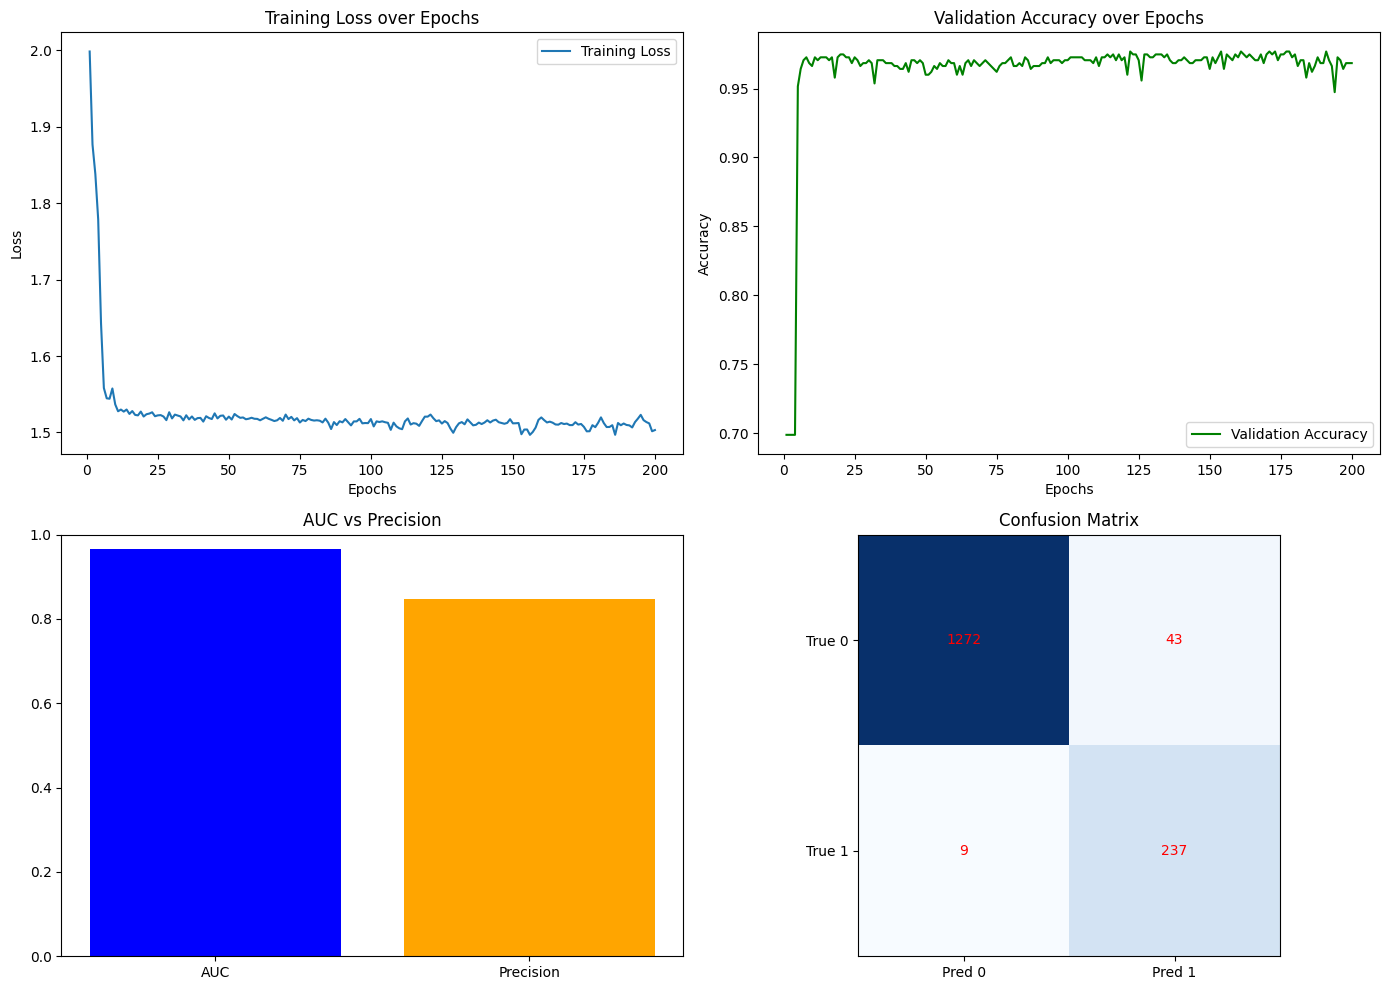

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable, Function
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn import metrics
import networkx as nx
import pandas as pd
import numpy as np
import os, re
import matplotlib.pyplot as plt  # Import for plotting

# Hyperparameters
num_epochs = 200  # Reduced for quicker visualization
batch_size = 32
learning_rate = 0.001
hidden_dim = 16

def plot_metrics(epoch_range, train_loss, val_accuracy, auc_score, precision, cm):
    """Generates 4 plots: Loss, Accuracy, AUC vs Precision, Confusion Matrix."""
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Training Loss over Epochs
    axs[0, 0].plot(epoch_range, train_loss, label='Training Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].set_title('Training Loss over Epochs')
    axs[0, 0].legend()

    # Plot 2: Validation Accuracy over Epochs
    axs[0, 1].plot(epoch_range, val_accuracy, label='Validation Accuracy', color='green')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].set_title('Validation Accuracy over Epochs')
    axs[0, 1].legend()

    # Plot 3: AUC vs Precision Comparison
    axs[1, 0].bar(['AUC', 'Precision'], [auc_score, precision], color=['blue', 'orange'])
    axs[1, 0].set_ylim([0, 1])
    axs[1, 0].set_title('AUC vs Precision')

    # Plot 4: Confusion Matrix
    axs[1, 1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 1].set_title('Confusion Matrix')
    axs[1, 1].set_xticks(np.arange(2))
    axs[1, 1].set_yticks(np.arange(2))
    axs[1, 1].set_xticklabels(['Pred 0', 'Pred 1'])
    axs[1, 1].set_yticklabels(['True 0', 'True 1'])
    for i in range(2):
        for j in range(2):
            axs[1, 1].text(j, i, cm[i, j], ha='center', va='center', color='red')

    plt.tight_layout()
    plt.show()


class edgeFeatures:
    def __init__(self, label=None, type=None, embeddings=None):
        self.label = label
        self.type = type
        self.embeddings = embeddings

def structuralGraph(realFileName, fakeFileName, dataset):
    # Process and load graphs
    dataReal = pd.read_csv(realFileName, sep=' ', skiprows=0)
    dataFake = pd.read_csv(fakeFileName, sep=' ', skiprows=0)

    train_Real_Graph, train_Fake_Graph = nx.Graph(), nx.Graph()
    test_Real_Graph, test_Fake_Graph = nx.Graph(), nx.Graph()

    real_edges = np.array(dataReal.iloc[:, 0:3])
    fake_edges = np.array(dataFake.iloc[:, 0:3])

    dataNewType = [9, 8, 7, 6, 5, 4] if dataset.lower() == 'facebook' else [2]

    for edge in real_edges:
        relation = edge[2]
        graph = test_Real_Graph if relation in dataNewType else train_Real_Graph
        graph.add_edge(edge[0], edge[1], relationship=relation)

    for edge in fake_edges:
        relation = edge[2]
        graph = test_Fake_Graph if relation in dataNewType else train_Fake_Graph
        graph.add_edge(edge[0], edge[1], relationship=relation)

    return train_Real_Graph, train_Fake_Graph, test_Real_Graph, test_Fake_Graph

def get_train_validate_test(dataset):
    # Load dataset and generate DataLoader objects
    realFileName = f'Datasets/{dataset}/realData.csv'
    fakeFileName = f'Datasets/{dataset}/fakeData.csv'
    node2vecReFile = f'Datasets/node2vecFeature/{dataset}Feature.txt'

    train_Real_Graph, train_Fake_Graph, test_Real_Graph, test_Fake_Graph = structuralGraph(
        realFileName, fakeFileName, dataset
    )
    data = pd.read_csv(node2vecReFile, sep=' ', skiprows=1, header=None)
    embeddings = np.array(data.iloc[:, 2:66])

    train_data, test_data = [], []

    for i, (nodeL, nodeR) in enumerate(zip(data.iloc[:, 0], data.iloc[:, 1])):
        nodel, noder = int(re.sub("\D", "", nodeL)), int(re.sub("\D", "", nodeR))
        edgeFeature = edgeFeatures(embeddings=embeddings[i])

        if train_Real_Graph.has_edge(nodel, noder):
            edgeFeature.label, edgeFeature.type = 1, train_Real_Graph.get_edge_data(nodel, noder)['relationship']
            train_data.append(edgeFeature)
        elif train_Fake_Graph.has_edge(nodel, noder):
            edgeFeature.label, edgeFeature.type = 0, train_Fake_Graph.get_edge_data(nodel, noder)['relationship']
            train_data.append(edgeFeature)
        elif test_Real_Graph.has_edge(nodel, noder):
            edgeFeature.label, edgeFeature.type = 1, test_Real_Graph.get_edge_data(nodel, noder)['relationship']
            test_data.append(edgeFeature)
        elif test_Fake_Graph.has_edge(nodel, noder):
            edgeFeature.label, edgeFeature.type = 0, test_Fake_Graph.get_edge_data(nodel, noder)['relationship']
            test_data.append(edgeFeature)

    train, validate = train_test_split(train_data, test_size=0.2)

    def create_dataset(data):
        return [
            [torch.tensor(f.embeddings, dtype=torch.float32),
             torch.tensor(f.label, dtype=torch.long),
             torch.tensor(f.type, dtype=torch.long)] for f in data
        ]

    return (
        DataLoader(create_dataset(train), batch_size=batch_size, shuffle=True),
        DataLoader(create_dataset(validate), batch_size=batch_size, shuffle=False),
        DataLoader(create_dataset(test_data), batch_size=batch_size, shuffle=False),
    )

def to_var(x):
    return Variable(x.cuda() if torch.cuda.is_available() else x)

class re_shape(Function):
    @staticmethod
    def forward(ctx, x):
        return x.view(len(x), -1)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.view(len(grad_output), 1, -1), None

class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output * -ctx.lambd, None

# Encoder Module
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(1, 1, 10, stride=1, padding=0)
        self.fc = nn.Linear(55, 32)

    def forward(self, x):
        x = self.conv(x)
        return re_shape.apply(self.fc(x))

# Decoder Module (Link Prediction)
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(32, 24), nn.ReLU(),
            nn.Linear(24, 16), nn.ReLU(),
            nn.Linear(16, 2), nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.fc(x)

# Discriminator Module (Relationship Type Prediction)
class Discriminator(nn.Module):
    def __init__(self, predicted_Type):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, predicted_Type), nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.fc(x)

# Complete TDAN Model
class TDAN(nn.Module):
    def __init__(self, predicted_Type):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.discriminator = Discriminator(predicted_Type)

    def forward(self, x):
        encoded = self.encoder(x)
        link_output = self.decoder(encoded)
        reverse_embeddings = GradReverse.apply(encoded, 1.0)
        type_output = self.discriminator(reverse_embeddings)
        return link_output, type_output

# Evaluation and Training Functions
def evaluate_model(loader, model):
    model.eval()
    all_labels, all_preds = [], []

    with torch.no_grad():
        for data, labels, _ in loader:
            outputs, _ = model(to_var(data).unsqueeze(1))
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.cpu().numpy())

    auc = metrics.roc_auc_score(all_labels, all_preds)
    precision = metrics.precision_score(all_labels, all_preds)
    accuracy = metrics.accuracy_score(all_labels, all_preds)
    cm = metrics.confusion_matrix(all_labels, all_preds)
    print(f"Final result: AUC -- {auc:.4f}, Precision -- {precision:.4f}, Accuracy -- {accuracy:.4f}")
    return auc, precision, cm

def train_tdan(train_loader, validate_loader, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss, val_accuracy = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for train_data, train_labels, type_labels in train_loader:
            optimizer.zero_grad()
            link_outputs, type_outputs = model(to_var(train_data).unsqueeze(1))
            loss = (criterion(link_outputs, to_var(train_labels)) +
                    criterion(type_outputs, to_var(type_labels)))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_loss.append(epoch_loss / len(train_loader))

        # Evaluate on validation set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for val_data, val_labels, _ in validate_loader:
                outputs, _ = model(to_var(val_data).unsqueeze(1))
                _, preds = torch.max(outputs, 1)
                correct += (preds == val_labels).sum().item()
                total += val_labels.size(0)

        accuracy = correct / total
        val_accuracy.append(accuracy)

        if epoch == 24:
            print("\nType-Specific Information at Epoch 25:")
            for _, (_, _, type_labels) in enumerate(train_loader):
                print(f'Type Labels: {type_labels.tolist()}')

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Accuracy: {accuracy:.4f}")

    return train_loss, val_accuracy

def main(predicted_Type, dataset):
    train_loader, validate_loader, test_loader = get_train_validate_test(dataset)
    model = TDAN(predicted_Type)

    # Train the model and collect training metrics
    train_loss, val_accuracy = train_tdan(train_loader, validate_loader, model)

    # Evaluate the model on the test set
    auc, precision, cm = evaluate_model(test_loader, model)

    # Generate plots
    epoch_range = list(range(1, num_epochs + 1))
    plot_metrics(epoch_range, train_loss, val_accuracy, auc, precision, cm)

if __name__ == '__main__':
    main(predicted_Type=4, dataset='Facebook')
